In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.utils import resample #to downsample the dataset
from sklearn.preprocessing import scale #Scale the dataset
from sklearn.svm import SVC #Support vector machine for classification
from sklearn.metrics import plot_confusion_matrix #Draws a Confusion Matrix

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [ ]:
#define mee loss function 
def mee(true_target, predicted_target):  # assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0

    for p in range(l):  # for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p, 0] - predicted_target[p, 0])  # difference between the x value of the true and predicted target
        y_diff = np.square(
            true_target[p, 1] - predicted_target[p, 1])  # difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l

    return res

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    for i in range(epochs):
        eval_model = eval_model.partial_fit(X_train,y_train)
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_scores.append(mee(y_train, y_train_predicted))
        test_scores.append(mean_squared_error(y_test, y_test_predicted))
        #result on test set
        train_loss.append(mee(y_train, y_train_predicted))
        test_loss.append(mean_squared_error(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss

In [ ]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]
df_blind_ts.drop(labels="idx", axis=1, inplace=True)

In [ ]:
df_task_tr.drop(labels="idx", axis=1, inplace=True)

In [ ]:
y = df_task_tr[['x','y']]
X = df_task_tr.drop(labels=['x','y'], axis=1)
X_test = df_blind_ts

print(y.shape)

(1477, 2)


In [ ]:
X_all = X.values
y_all = y.values

In [ ]:
#prepare validation set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1, random_state=420)
print(f"X shape: {X_train.shape}")
print(f"X validation shape: {X_validation.shape}")
print(f"y shape: {y_train.shape}")
print(f"y validation shape: {y_validation.shape}")

X shape: (1329, 10)
X validation shape: (148, 10)
y shape: (1329, 2)
y validation shape: (148, 2)


In [ ]:
from sklearn.preprocessing import scale #Scale the dataset

X_train_scaled = scale(X_train)
X_val_scaled = scale(X_validation)
X_test_scaled = scale (X_test)

In [ ]:
y_train = y_train[['x', 'y']]
y_validation = y_validation[['x', 'y']]

In [ ]:
X_train_C = np.ascontiguousarray(X_train_scaled, dtype=np.double)
X_val_C = np.ascontiguousarray(X_val_scaled, dtype=np.double)
X_test_C = np.ascontiguousarray(X_test_scaled, dtype=np.double)

In [ ]:
y_train_C = np.ascontiguousarray(y_train.values, dtype=np.double)
y_validation_C = np.ascontiguousarray(y_validation.values, dtype=np.double)

In [ ]:
pipe_svr = Pipeline([('reg', MultiOutputRegressor(SVR()))])
grid_param_svr = {
    'reg__estimator__C':[0.1, 0.5, 0.8, 0.9, 1, 2, 5, 10],
    'reg__estimator__epsilon': [0, 0.01, 0.1, 0.5, 1, 2],
    'reg__estimator__gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'reg__estimator__kernel':  ['linear', 'rbf', 'sigmoid']
}

optimal_par = RandomizedSearchCV(
    estimator=pipe_svr,
    param_distributions=grid_param_svr,
    n_iter=100,
    cv=10,
    scoring='neg_mean_squared_error',
    verbose=0
)

optimal_par.fit(X_train_scaled, y_train)
print(optimal_par.best_params_)

{'reg__estimator__kernel': 'rbf', 'reg__estimator__gamma': 0.1, 'reg__estimator__epsilon': 0.1, 'reg__estimator__C': 10}


In [ ]:
best_model = optimal_par.best_estimator_
best_model.fit(X_train_scaled, y_train)
best_model.score(X_val_scaled, y_validation)

0.9582132125208995

In [ ]:
df_results_cup = pd.DataFrame(data=optimal_par.cv_results_) #trasform into a pandas dataframe
df_results_cup

#https://github.com/scikit-learn/scikit-learn/issues/2439 se è negativo controlla questo

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__estimator__kernel,param_reg__estimator__gamma,param_reg__estimator__epsilon,param_reg__estimator__C,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.314283,0.029167,0.033344,0.009377,rbf,1,0.5,0.8,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-6.587775,...,-5.390606,-4.887807,-6.061966,-5.625449,-5.134024,-5.188962,-6.222389,-5.688563,0.528835,67
1,0.445288,0.047486,0.033607,0.011873,sigmoid,0.1,0,2,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",-339.688327,...,-378.832606,-341.695256,-345.458416,-358.953148,-373.771652,-380.463449,-389.000064,-375.761072,29.616589,94
2,0.401840,0.031792,0.016514,0.006322,linear,0.1,0.01,1,"{'reg__estimator__kernel': 'linear', 'reg__est...",-2.603938,...,-2.326448,-2.032434,-2.391072,-2.411000,-2.484580,-2.276472,-2.281647,-2.375944,0.167662,36
3,0.477795,0.042194,0.037819,0.008588,sigmoid,1,1,0.1,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",-96.672499,...,-188.449793,-182.685630,-138.870352,-169.104816,-173.197414,-185.145006,-194.063424,-165.374309,29.234329,92
4,0.166627,0.019739,0.015872,0.009183,linear,0.1,1,0.1,"{'reg__estimator__kernel': 'linear', 'reg__est...",-2.560491,...,-2.326736,-1.977557,-2.382271,-2.429899,-2.524101,-2.274122,-2.250033,-2.359993,0.168962,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.363024,0.054132,0.037809,0.013790,rbf,1,0,0.9,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-6.159000,...,-5.006779,-4.491135,-5.599712,-5.242466,-4.717016,-4.773018,-5.794432,-5.275697,0.523316,65
96,0.046744,0.012381,0.009035,0.007752,rbf,scale,2,0.5,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-2.000855,...,-1.648558,-1.347663,-1.473622,-1.823288,-1.789024,-1.672058,-1.781387,-1.712914,0.204205,15
97,0.311305,0.090612,0.028943,0.011942,sigmoid,0.0001,0.01,0.5,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",-30.850422,...,-27.822164,-26.410435,-31.046835,-29.201792,-29.789207,-27.629102,-26.873110,-28.588302,1.526241,81
98,0.236294,0.013466,0.011044,0.007281,linear,0.001,0.1,1,"{'reg__estimator__kernel': 'linear', 'reg__est...",-2.602501,...,-2.314353,-2.030210,-2.383227,-2.408617,-2.490560,-2.269912,-2.291521,-2.373809,0.167938,31


In [ ]:
C_BEST = optimal_par.best_params_['reg__estimator__C']
GAMMA = optimal_par.best_params_['reg__estimator__gamma']
KERNEL = optimal_par.best_params_['reg__estimator__kernel']
EPSILON = optimal_par.best_params_['reg__estimator__epsilon']

clf_svr_cup = SVR(C=C_BEST, gamma=GAMMA, kernel=KERNEL, epsilon=EPSILON)
mor = MultiOutputRegressor(clf_svr_cup)
mor.fit(X_train_scaled, y_train)

train_pred = mor.predict(X_train_scaled)
val_pred = mor.predict(X_val_scaled)

In [ ]:
mse_one = mean_squared_error(y_train, train_pred)
print(f'MSE for first regressor: {mse_one}')

MSE for first regressor: 0.796452626908405


In [ ]:
mse_two = mean_squared_error(y_validation, val_pred)
print(f'MSE for first regressor: {mse_two}')

MSE for first regressor: 0.8491383204033143


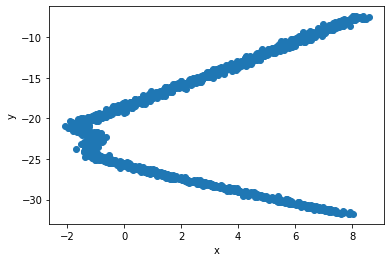

In [ ]:
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(df_visual['x'], df_visual['y'])

In [ ]:
def plot_coordinates(model, X, true_y = None):
    y_predicted = model.predict(X)
    y_predicted = pd.DataFrame(data=y_predicted, columns=["x", "y"])
    if not None:
        true_y = pd.DataFrame(data=true_y, columns=["x", "y"])
        plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4')

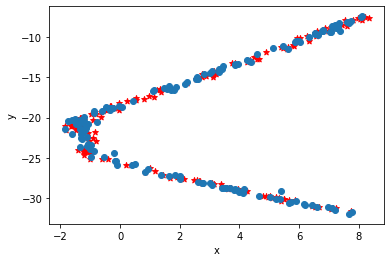

In [ ]:
plot_coordinates(mor, X_val_scaled, y_validation)

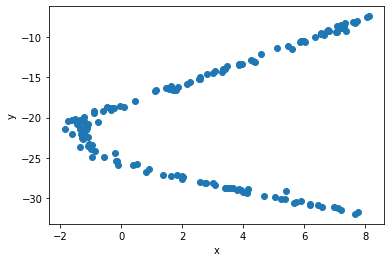

In [ ]:
plot_coordinates(mor, X_val_scaled)

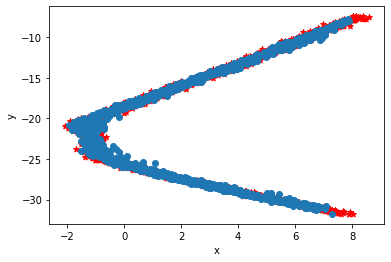

In [ ]:
plot_coordinates(mor, X_all, y_all)

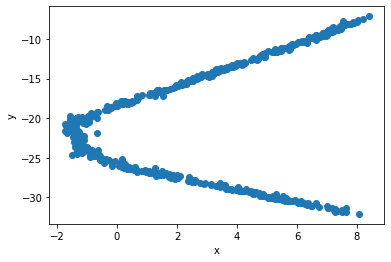

In [ ]:
plot_coordinates(mor, X_test_scaled)

In [ ]:
print(f"Accuracy: {mor.score(X_val_scaled, y_validation)}")
print(f"MEE: {mee(y_validation.values, val_pred)}")

Accuracy: 0.9582132125208995
MEE: 1.0426407156635356


### MEE scoring
Now, we made a RandomizedSearchCV with mee scoring.

In [ ]:
optimal_par_mee = RandomizedSearchCV(
    estimator=pipe_svr,
    param_distributions=grid_param_svr,
    n_iter=100,
    cv=10,
    scoring=make_scorer(mee, greater_is_better=False),
    verbose=0
)

optimal_par_mee.fit(X_train_scaled, y_train.values)
print(optimal_par_mee.best_params_)

{'reg__estimator__kernel': 'rbf', 'reg__estimator__gamma': 0.1, 'reg__estimator__epsilon': 0.5, 'reg__estimator__C': 10}


In [ ]:
best_model = optimal_par_mee.best_estimator_
best_model.fit(X_train_scaled, y_train)
best_model.score(X_val_scaled, y_validation)

0.9589373356596956

In [ ]:
df_results_cup = pd.DataFrame(data=optimal_par_mee.cv_results_) #trasform into a pandas dataframe
df_results_cup

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__estimator__kernel,param_reg__estimator__gamma,param_reg__estimator__epsilon,param_reg__estimator__C,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.161532,0.019408,0.019150,0.012367,sigmoid,0.0001,2,0.9,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",-7.012795,...,-6.612533,-6.506893,-7.081430,-6.787642,-6.894525,-6.629897,-6.526274,-6.731176,0.194697,78
1,0.224579,0.009527,0.022283,0.011234,sigmoid,0.00001,0.1,0.5,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",-7.606225,...,-7.167186,-7.060636,-7.653376,-7.338449,-7.454694,-7.181861,-7.053195,-7.288114,0.206532,86
2,0.319394,0.030926,0.022657,0.007674,sigmoid,scale,1,0.9,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",-9.806267,...,-10.371846,-9.903026,-9.773063,-9.937344,-10.437117,-10.592242,-10.912918,-10.370851,0.472564,91
3,0.240774,0.022590,0.024966,0.011443,sigmoid,0.0001,0,0.1,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",-7.564802,...,-7.133174,-7.026100,-7.617337,-7.299866,-7.424427,-7.143835,-7.014036,-7.251682,0.206225,84
4,0.368228,0.027029,0.022995,0.010511,rbf,0.1,0.1,10,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-1.207562,...,-1.082505,-1.035927,-1.114696,-1.218145,-1.146244,-1.189561,-1.222730,-1.159135,0.093870,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.291985,0.007363,0.011993,0.000584,linear,0.0001,0.1,0.5,"{'reg__estimator__kernel': 'linear', 'reg__est...",-2.004560,...,-1.900919,-1.742507,-1.921244,-1.932264,-1.966907,-1.902738,-1.902750,-1.920685,0.073171,36
96,0.157874,0.012372,0.024637,0.011215,rbf,0.01,1,0.5,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-1.809625,...,-1.723811,-1.533361,-1.724160,-1.779104,-1.794071,-1.728302,-1.664075,-1.728523,0.083427,17
97,0.550202,0.112704,0.010952,0.008474,linear,0.001,0.01,5,"{'reg__estimator__kernel': 'linear', 'reg__est...",-2.000806,...,-1.906597,-1.747700,-1.925607,-1.932278,-1.962142,-1.906669,-1.897092,-1.921861,0.071651,49
98,0.080560,0.014112,0.012629,0.010053,rbf,scale,1,0.9,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-1.370420,...,-1.185381,-1.094963,-1.169686,-1.289427,-1.239464,-1.277565,-1.283371,-1.245039,0.103280,9


In [ ]:
df_results = pd.DataFrame(data=optimal_par_mee.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=True, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:100] #keep only top 50 models
df_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__estimator__kernel,param_reg__estimator__gamma,param_reg__estimator__epsilon,param_reg__estimator__C,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
25,0.234786,0.033771,0.023171,0.014467,rbf,0.1,0.5,10,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-1.197364,...,-1.084497,-1.014444,-1.084127,-1.216867,-1.141230,-1.170604,-1.194763,-1.147131,0.097870,1
38,0.465775,0.048035,0.040220,0.014049,rbf,0.1,0.1,5,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-1.200271,...,-1.100461,-1.034966,-1.105456,-1.208320,-1.137123,-1.194610,-1.221238,-1.159039,0.093284,2
4,0.368228,0.027029,0.022995,0.010511,rbf,0.1,0.1,10,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-1.207562,...,-1.082505,-1.035927,-1.114696,-1.218145,-1.146244,-1.189561,-1.222730,-1.159135,0.093870,3
27,0.731248,0.020237,0.044752,0.011990,rbf,scale,0,10,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-1.224858,...,-1.095537,-1.045017,-1.130750,-1.232592,-1.152714,-1.185656,-1.232905,-1.169554,0.091136,4
77,0.355931,0.015046,0.030527,0.007956,rbf,scale,0.1,0.9,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-1.294281,...,-1.151472,-1.059258,-1.147161,-1.232402,-1.183373,-1.233216,-1.262444,-1.201227,0.091138,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.393818,0.087499,0.033448,0.014215,sigmoid,1,1,0.8,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",-73.259337,...,-99.465066,-103.226295,-90.165929,-97.864404,-98.593898,-102.272957,-105.855388,-96.345597,8.832072,96
21,0.493158,0.036056,0.045131,0.013518,sigmoid,1,0.01,0.9,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",-81.994389,...,-111.698208,-116.329082,-101.654426,-109.929146,-110.790086,-114.838953,-118.935927,-108.193126,9.987111,97
92,0.475173,0.022020,0.037332,0.011775,sigmoid,0.1,0.5,10,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",-111.070400,...,-110.898214,-105.802358,-104.111479,-106.694506,-114.169947,-110.203671,-115.801763,-111.347127,4.563349,98
28,0.425561,0.102664,0.035496,0.013038,sigmoid,1,1,5,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",-450.403867,...,-612.862666,-641.524992,-559.581098,-604.912710,-611.090857,-632.166018,-654.193121,-594.716500,55.147949,99


In [ ]:
C_BEST = optimal_par.best_params_['reg__estimator__C']
GAMMA = optimal_par.best_params_['reg__estimator__gamma']
KERNEL = optimal_par.best_params_['reg__estimator__kernel']
EPSILON = optimal_par.best_params_['reg__estimator__epsilon']

clf_svr_cup = SVR(C=C_BEST, gamma=GAMMA, kernel=KERNEL, epsilon=EPSILON)
mor_mee = MultiOutputRegressor(clf_svr_cup)
mor_mee.fit(X_train_scaled, y_train)

train_pred = mor_mee.predict(X_train_scaled)
val_pred = mor_mee.predict(X_val_scaled)

In [ ]:
print(f"Accuracy: {mor_mee.score(X_train_scaled, y_train.values)}")
print(f"MEE: {mee(y_train.values, train_pred)}")

Accuracy: 0.9553916165568044
MEE: 0.898094659377827


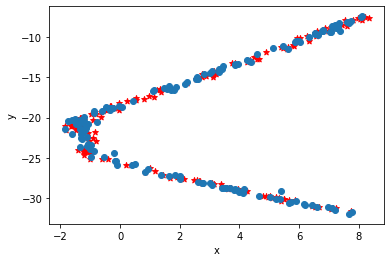

In [ ]:
plot_coordinates(mor_mee, X_val_scaled, y_validation)

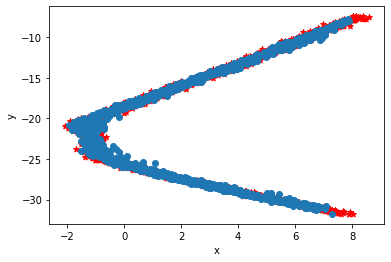

In [ ]:
plot_coordinates(mor_mee, X_all, y_all)

In [ ]:
print(f"Accuracy: {mor_mee.score(X_val_scaled, y_validation)}")
print(f"MEE: {mee(y_validation.values, val_pred)}")

Accuracy: 0.9582132125208995
MEE: 1.0426407156635356


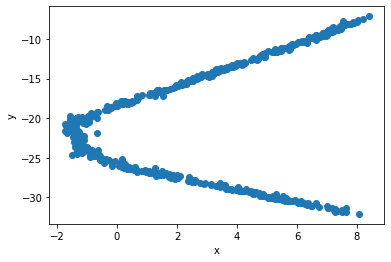

In [ ]:
plot_coordinates(mor_mee, X_test_scaled)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>